### NLP Comment Data

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("comments") \
    .config("spark.dynamicAllocation.executorIdleTimeout", "300s")\
    .config("spark.executor.memory", "12g") \
    .config("spark.executor.cores", "3") \
    .config("spark.executor.instances", "2") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *

import matplotlib.pyplot as plt
import pandas as pd

from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, udf, to_timestamp, desc, year, count, round,
    monotonically_increasing_id, concat, lit, explode,
    coalesce, from_json, from_unixtime, length, date_format,
    avg, weekofyear, dayofyear
)
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, ArrayType, FloatType,
import pyspark.sql.functions as F

import json
import re
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import NGram
from pyspark.ml.functions import vector_to_array
from pyspark.ml.clustering import LDA

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
# reading in first, partitioning
data = spark.read.parquet("s3://131313113finalproject/cleaned_data_2").repartition(3).persist()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
data = data.withColumn('time', to_timestamp(data['time']))
data = data.withColumn('score', data['score'].cast('int'))

data = data.withColumn('year', year(col('time')))

data.printSchema()
print('Total Rows: %d' % data.count())
print('Total Columns: %d' % len(data.dtypes))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- body: string (nullable = true)
 |-- author: string (nullable = true)
 |-- score: integer (nullable = true)
 |-- id: string (nullable = true)
 |-- link_id: string (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- year: integer (nullable = true)

Total Rows: 142924
Total Columns: 9

# Key Word Extractor

I chose to use a keyword extractor on the comment data to identify the main ideas without having to read through all the comments. This approach is particularly useful given the large volume of data and the length of some comments. For an example, I selected the top 3 comments with the highest score from each year to try and see if there were any major shifts in what we being up/down voted.

I based this code off of JonSnowLabs, as cited in the Repo. https://github.com/JohnSnowLabs/spark-nlp/blob/master/examples/python/annotation/text/english/keyword-extraction/Keyword_Extraction_YAKE.ipynb

In [6]:
# same stopwords as before, but this time leaving in abortion
stopwords = StopWordsCleaner().getStopWords()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
# doc assembler
document = DocumentAssembler() \
            .setInputCol("body") \
            .setOutputCol("document")

# sentence detector
sentenceDetector = SentenceDetector() \
            .setInputCols("document") \
            .setOutputCol("sentence")

# transforming col
tokenizer = Tokenizer() \
    .setInputCols(["sentence"]) \
    .setOutputCol("token")

# normalizing col
normalizer = Normalizer() \
    .setInputCols(['token']) \
    .setOutputCol("normalized") \
    .setLowercase(True)

# keyword extractor
keywords = YakeKeywordExtraction() \
            .setInputCols("normalized") \
            .setOutputCol("keywords") \
            .setMinNGrams(1) \
            .setMaxNGrams(4)\
            .setNKeywords(10)\
            .setStopWords(stopwords)

keyword_pipeline = Pipeline(stages=[document, sentenceDetector, tokenizer, normalizer, keywords])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
keyword_df = spark.createDataFrame([['']]).toDF('body')

keyword_model = keyword_pipeline.fit(keyword_df)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
def highlight(body, keywords):
    for k in keywords:
        body = (re.sub(r'(\b%s\b)'%k, r'<span style="background-color: yellow;">\1</span>', body, flags=re.IGNORECASE))
    return body

highlight_udf = udf(highlight, StringType())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
def keywords_by_year(year):
    
    by_year = data.filter(data['year'] == year)
    high_scores = by_year.orderBy('score', ascending=False)

    keyword_df = spark.createDataFrame([['']]).toDF('body')
    keyword_model = keyword_pipeline.fit(keyword_df)
    
    body_df = high_scores.select('body')
    
    result = keyword_pipeline.fit(body_df).transform(body_df)
    result = result.withColumn('keywords', F.array_distinct("keywords.result"))
    
    result = result.withColumn("highlighted_keywords",highlight_udf('body','keywords'))
    
    results = []

    for r in result.select("highlighted_keywords").limit(3).collect():
        results.append((r.highlighted_keywords))
        results.append('NEXT')
        
    return results

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
y_2012 = keywords_by_year(2012)
y_2014 = keywords_by_year(2014)
y_2016 = keywords_by_year(2016)
y_2018 = keywords_by_year(2018)
y_2020 = keywords_by_year(2020)
y_2022 = keywords_by_year(2022)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# 2012

<span style="background-color: yellow;">Yeah</span>, but prolife or <span style="background-color: yellow;">prochoice</span>, you <span style="background-color: yellow;">want</span> to <span style="background-color: yellow;">get</span> as far <span style="background-color: yellow;">away</span> as you can from a <span style="background-color: yellow;">political</span> candidate that won\'t <span style="background-color: yellow;">let</span> you abort a child as a <span style="background-color: yellow;">result</span> of <span style="background-color: yellow;">rape</span>. The inability to properly vet candidates on this tiny, minute issue just cost the GOP two senate seats in red <span style="background-color: yellow;">states</span>.'


'Some <span style="background-color: yellow;">people</span> are <span style="background-color: yellow;">personally</span> pro-life. Meaning they would <span style="background-color: yellow;">never</span> <span style="background-color: yellow;">get</span> an <span style="background-color: yellow;">abortion</span> themselves. But when Conservatives are anti-<span style="background-color: yellow;">abortion</span>, this turns off <span style="background-color: yellow;">female</span> <span style="background-color: yellow;">voters</span> who believe that <span style="background-color: yellow;">even</span> <span style="background-color: yellow;">people</span> they do not agree with should not be told whether or not they can have an <span style="background-color: yellow;">abortion</span>. It\'s like <span style="background-color: yellow;">people</span> who are "pro-<span style="background-color: yellow;">marijuana</span>."  Many of them would <span style="background-color: yellow;">never</span> <span style="background-color: yellow;">smoke</span> <span style="background-color: yellow;">marijuana</span>, they find it <span style="background-color: yellow;">personally</span> disgusting, but they do not support laws that make it illegal to <span style="background-color: yellow;">smoke</span> <span style="background-color: yellow;">marijuana</span>. So yeah, telling women what they can and cannot do with their bodies becomes an issue for <span style="background-color: yellow;">female</span> <span style="background-color: yellow;">voters</span> <span style="background-color: yellow;">even</span> if these women would <span style="background-color: yellow;">never</span> <span style="background-color: yellow;">personally</span> <span style="background-color: yellow;">get</span> an <span style="background-color: yellow;">abortion</span> themselves. 


'Why isn\'t this <span style="background-color: yellow;">getting</span> any <span style="background-color: yellow;">attention</span>? <span style="background-color: yellow;">Oh</span> <span style="background-color: yellow;">wait</span>, this is <span style="background-color: yellow;">reddit</span>. MY <span style="background-color: yellow;">bad</span>.


# 2014

<span style="background-color: yellow;">BLACKLIVESMATTER</span><span style="background-color: yellow;">except</span> in the <span style="background-color: yellow;">case</span> of <span style="background-color: yellow;">abortion</span> then we could <span style="background-color: yellow;">give</span> <span style="background-color: yellow;">two</span> <span style="background-color: yellow;">shits</span>.'

'I\'m glad my <span style="background-color: yellow;">mother</span> did not have an <span style="background-color: yellow;">abortion</span>.  She was told too by "<span style="background-color: yellow;">friends</span>" to do it, but chose to keep her <span style="background-color: yellow;">baby</span>.  As a single <span style="background-color: yellow;">mom</span>, she couldn\'t give me much, but she <span style="background-color: yellow;">taught</span> me respect for hard work through word and <span style="background-color: yellow;">deed</span>.  She <span style="background-color: yellow;">taught</span> me to that to be <span style="background-color: yellow;">proud</span> of yourself, you have to first do something to be <span style="background-color: yellow;">proud</span> of.  I think I\'ve done pretty well in this world.  Thanks <span style="background-color: yellow;">Mom</span>!'

'This is <span style="background-color: yellow;">sickening</span>. On the positive <span style="background-color: yellow;">side</span> at <span style="background-color: yellow;">least</span> he\'s a useful <span style="background-color: yellow;">psycho</span>, he is <span style="background-color: yellow;">unashamed</span> to <span style="background-color: yellow;">say</span> out <span style="background-color: yellow;">loud</span> the things most <span style="background-color: yellow;">liberals</span> only <span style="background-color: yellow;">think</span> to themselves. 

# 2016
I <span style="background-color: yellow;">like</span> how he <span style="background-color: yellow;">turned</span> the <span style="background-color: yellow;">table</span> and <span style="background-color: yellow;">called</span> <span style="background-color: yellow;">liberals</span> the <span style="background-color: yellow;">extremists</span>. <span style="background-color: yellow;">Conservatives</span> don\'t do that <span style="background-color: yellow;">enough</span>.'

'<span style="background-color: yellow;">Yes</span>, <span style="background-color: yellow;">Fucking</span> <span style="background-color: yellow;">YesOnly</span> a <span style="background-color: yellow;">Liberal</span> could <span style="background-color: yellow;">view</span> this <span style="background-color: yellow;">negatively</span> <span style="background-color: yellow;">Fucking</span> <span style="background-color: yellow;">Yes</span>

'Rubio\'s answer was <span style="background-color: yellow;">fantastic</span>. He\'s <span style="background-color: yellow;">right</span>. <span style="background-color: yellow;">Unborn</span> children <span style="background-color: yellow;">deserve</span> basic human <span style="background-color: yellow;">rights</span>, and life takes precedence over convenience.Why has the <span style="background-color: yellow;">media</span> not asked democrats about their extreme views on abortions? Why doesn\'t the <span style="background-color: yellow;">media</span> slam them with the tough questions like they do the GOP candidates? I want a moderator to <span style="background-color: yellow;">ask</span> Sanders &amp; <span style="background-color: yellow;">Clinton</span> straight up if they believe a 20-something week old <span style="background-color: yellow;">unborn</span> child is a worthless "clump of cells" that has absolutely no <span style="background-color: yellow;">rights</span> (though, naturally, they would dodge the <span style="background-color: yellow;">question</span> and instead say "Women <span style="background-color: yellow;">deserve</span> the <span style="background-color: yellow;">right</span> to control their own bodies" rather than respond to the root <span style="background-color: yellow;">question</span>), and <span style="background-color: yellow;">ask</span> <span style="background-color: yellow;">Clinton</span> why she believes partial birth abortion, a barbaric and outlawed practice, is okay.''

# 2018
'I love how he <span style="background-color: yellow;">incriminates</span> himself. “I just wanted to <span style="background-color: yellow;">hit</span> your <span style="background-color: yellow;">phone</span>” <span style="background-color: yellow;">implies</span> <span style="background-color: yellow;">intent</span> to <span style="background-color: yellow;">hit</span> and <span style="background-color: yellow;">cause</span> some <span style="background-color: yellow;">damage</span>. He could’ve simply <span style="background-color: yellow;">said</span> “I didn’t <span style="background-color: yellow;">mean</span> to <span style="background-color: yellow;">hit</span> you, I was <span style="background-color: yellow;">joking</span>”

'“We must do more to <span style="background-color: yellow;">protect</span> <span style="background-color: yellow;">women</span>...<span style="background-color: yellow;">unless</span> they <span style="background-color: yellow;">disagree</span> with <span style="background-color: yellow;">us</span>. <span style="background-color: yellow;">Fuck</span> those <span style="background-color: yellow;">bitches</span>. You can kick them in the <span style="background-color: yellow;">face</span>.”-<span style="background-color: yellow;">Tolerant</span> Leftists in 2018'

'Is this person arguing for <span style="background-color: yellow;">eliminating certain</span> <span style="background-color: yellow;">undesirable populations</span> for pre-crime?When <span style="background-color: yellow;">progressive utopia</span> <span style="background-color: yellow;">inevitably becomes</span> a dystopian fever <span style="background-color: yellow;">dream</span>.', 


# 2020
If she\'d give up on the <span style="background-color: yellow;">gun control</span> stuff she\'d be like a <span style="background-color: yellow;">good center</span> left rand <span style="background-color: yellow;">paul</span>.

'<span style="background-color: yellow;">Damn</span> she\'s more <span style="background-color: yellow;">conservative</span> than some <span style="background-color: yellow;">Republicans</span>.

'Then they will <span style="background-color: yellow;">say</span> the <span style="background-color: yellow;">republicans</span> <span style="background-color: yellow;">blocked</span> a <span style="background-color: yellow;">coronavirus</span> <span style="background-color: yellow;">bill</span>.'

# 2022
This is the type of <span style="background-color: yellow;">thing</span> that will lose the election in <span style="background-color: yellow;">November</span>. The fight against unrestricted access to abortion is <span style="background-color: yellow;">one</span> <span style="background-color: yellow;">thing</span>, and I understand that unborn <span style="background-color: yellow;">life</span> is precious, but how does <span style="background-color: yellow;">one</span> demand that an assaulted <span style="background-color: yellow;">woman</span> <span style="background-color: yellow;">carry</span> her attacker\'s pregnancy to <span style="background-color: yellow;">term</span>? That\'s <span style="background-color: yellow;">life</span> created out of violence, and you can\'t tell me to ignore the emotions of the argument. If my wife was attacked, became pregnant as a <span style="background-color: yellow;">result</span>, and someone came to her and said "Too bad, that\'s unfortunate, but you\'re required to <span style="background-color: yellow;">carry</span> to <span style="background-color: yellow;">term</span>"... we\'re <span style="background-color: yellow;">going</span> to have serious fucking problems.You want to ride the moral high horse of these actions, do so, but don\'t pretend that you aren\'t entirely throwing aside the trauma a <span style="background-color: yellow;">woman</span> has endured as a <span style="background-color: yellow;">result</span> of it. There\'s zero balance here.'

'This is where I <span style="background-color: yellow;">diverge</span> from my <span style="background-color: yellow;">fellow</span> <span style="background-color: yellow;">conservatives</span>. I feel that <span style="background-color: yellow;">abortion</span> should be <span style="background-color: yellow;">legal</span> and <span style="background-color: yellow;">safe</span>. Don’t want <span style="background-color: yellow;">one</span>, don’t <span style="background-color: yellow;">get</span> <span style="background-color: yellow;">one</span>.'

'they already don\'t have any <span style="background-color: yellow;">jurisdiction</span> over it. in fact, that\'s <span style="background-color: yellow;">LITERALLY</span> what their <span style="background-color: yellow;">ruling</span> was. they said the <span style="background-color: yellow;">constitution</span> doesn\'t say anything about it so in absence of <span style="background-color: yellow;">federal</span> <span style="background-color: yellow;">law</span>, <span style="background-color: yellow;">states</span> can do as they <span style="background-color: yellow;">please</span>.'

## Bigrams

Much like the post data, I decided to look at bigrams again as well. These were extremely helpful in identifying the temporal changes in topics.

In [13]:
stopwords.append('v')
stopwords.append('V')

# already have doc col

# transforming col
tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

# taking out stop words
stopwords_cleaner = StopWordsCleaner()\
      .setInputCols("token")\
      .setOutputCol("stopworded")\
      .setStopWords(stopwords) \
      .setCaseSensitive(False)

# normalizing col
normalizer = Normalizer() \
    .setInputCols(['stopworded']) \
    .setOutputCol("normalized") \
    .setLowercase(True)

# finishing
finisher = Finisher() \
    .setInputCols(["normalized"]) \
    .setOutputCols(["tokens"]) \
    .setOutputAsArray(True) \
    .setCleanAnnotations(False)

# takes input of tokens
ngram = NGram(n=2, inputCol="tokens", outputCol="bigrams")
bigram_pipeline = Pipeline(stages=[document, 
                            tokenizer,
                            stopwords_cleaner,
                            normalizer,
                            finisher,
                            ngram])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
pipeline_model = bigram_pipeline.fit(data)
result = pipeline_model.transform(data)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
result_exploded = result.select(explode("bigrams").alias("bigram"))
exploded_counts = result_exploded.groupBy('bigram').count()

filtered = exploded_counts.filter(exploded_counts['count'] > 15)

print('Total Bigrams: %d' % filtered.count())
print()
print('Top Bigrams Overall')
filtered.orderBy('count', ascending=False).show(20)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Bigrams: 12633

Top Bigrams Overall
+------------------+-----+
|            bigram|count|
+------------------+-----+
|     birth control| 2873|
|        human life| 2322|
|     supreme court| 1669|
|planned parenthood| 1415|
|          roe wade| 1367|
|          pro life| 1089|
|          year old| 1022|
|       rape incest|  999|
|        right life|  968|
|      get abortion|  963|
|        pro choice|  948|
|         late term|  944|
|       life begins|  938|
|      get pregnant|  935|
|         dont want|  895|
|        dont think|  791|
|       many people|  773|
|   abortion murder|  753|
|       sounds like|  753|
|      unborn child|  750|
+------------------+-----+
only showing top 20 rows

In [16]:
def ngram_by_year(year):
    
    # filtering by year
    processed_df = data.filter(data['year'] == year)
    
    # creating Ngram pipeline
    pipeline_model = bigram_pipeline.fit(processed_df)
    result = pipeline_model.transform(processed_df)
    result_exploded = result.select(explode("bigrams").alias("bigram"))
    exploded_counts = result_exploded.groupBy('bigram').count()
    
    filtered = exploded_counts.filter(exploded_counts['count'] > 10)
    
    top_grams = filtered.orderBy('count', ascending=False)
    print(f'Top Bigrams in {year}')
    top_grams.show(10)
    print ('--'*50)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
ngram_by_year(2014)
ngram_by_year(2016)
ngram_by_year(2018)
ngram_by_year(2020)
ngram_by_year(2022)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Top Bigrams in 2014
+--------------------+-----+
|              bigram|count|
+--------------------+-----+
|  planned parenthood|   35|
|       birth control|   23|
|          human life|   16|
|           human dna|   15|
|undocumented immi...|   14|
|           take care|   12|
|    abortion clinics|   12|
|          right life|   12|
|        gay marriage|   12|
|     abortion murder|   11|
+--------------------+-----+
only showing top 10 rows

----------------------------------------------------------------------------------------------------
Top Bigrams in 2016
+------------------+-----+
|            bigram|count|
+------------------+-----+
|        human life|  172|
|     birth control|  110|
|     supreme court|  109|
|          pro life|   70|
|        right life|   69|
|      unborn child|   65|
|      human beings|   57|
|          roe wade|   57|
|planned parenthood|   51|
|         late term|   47|
+------------------+-----+
only showing top 10 rows

-----------------------

# LDA

In [18]:
lst = ['abortion', 'abortions', 'im', 'isnt', 'oh', 'youre', 'dont','like', 'get', 'gt', 'ive', 'th']
stopwords = stopwords + lst

# transforming col
tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

# normalizing col
normalizer = Normalizer() \
    .setInputCols(['token']) \
    .setOutputCol("normalized") \
    .setLowercase(True)

# taking out stop words
stopwords_cleaner = StopWordsCleaner()\
      .setInputCols("normalized")\
      .setOutputCol("stopworded")\
      .setStopWords(stopwords) \
      .setCaseSensitive(False)

# finishing
finisher = Finisher() \
    .setInputCols(["stopworded"]) \
    .setOutputCols(["tokens"]) \
    .setOutputAsArray(True) \
    .setCleanAnnotations(False)

lda_pipeline = Pipeline(stages=[document, 
                            tokenizer,
                            normalizer,
                            stopwords_cleaner,
                            finisher])

pipeline_model = lda_pipeline.fit(data)
lda_result = pipeline_model.transform(data)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
tokens_df = lda_result.select('tokens')

# count vectorizing
cv = CountVectorizer(inputCol="tokens", outputCol="features", vocabSize=2000, minDF = 10.0)

# fitting model
cv_model = cv.fit(tokens_df)

# transforming
vectorized_tokens = cv_model.transform(tokens_df)

# results, truncating for readibility
vectorized_tokens.select("tokens", "features").show(truncate=True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+
|              tokens|            features|
+--------------------+--------------------+
|[legal, allowed, ...|(2000,[5,74,198,2...|
|[always, murder, ...|(2000,[16,95],[1....|
|[let, anyone, wal...|(2000,[12,101,184...|
|[theyre, special,...|(2000,[15,18,24,3...|
|[right, nearly, t...|(2000,[1,3,15,60,...|
|[unfortunately, p...|(2000,[111,117,15...|
|[also, high, risk...|(2000,[1,6,10,11,...|
| [want, slaves, one]|(2000,[4,5,1667],...|
|[hmm, peaceful, p...|(2000,[0,14,110,1...|
|[according, ameri...|(2000,[12,55,184,...|
|[hate, liberal, a...|(2000,[246,376,10...|
|[rightfully, must...|(2000,[0,5,17,18,...|
|[itd, thing, happ...|(2000,[51,222,908...|
|[id, buy, skinny,...|(2000,[115,139,15...|
|[basing, policy, ...|(2000,[28,416,441...|
|[satanic, temples...|(2000,[140,469,16...|
|[seems, alot, ste...|(2000,[2,4,7,10,1...|
|[many, learned, l...|(2000,[28,39,53,5...|
|[terribleroe, def...|(2000,[586,1095,1...|
|[gtcan, anybody, ...|(2000,[15,

In [20]:
# STARTING LDA
num_topics = 12
lda = LDA(k=num_topics, maxIter=75, seed = 13)

model = lda.fit(vectorized_tokens)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
def printed_topics(lda_model, num_words=10):
    
    words = cv_model.vocabulary
    topics_matrix = model.describeTopics()

    topic_data = topics_matrix.collect()
    
    topic_lst = []
    
    for topic_idx, topic_row in enumerate(topic_data):
        topic_indices = topic_row["termIndices"]
        topic_terms = [words[idx] for idx in topic_indices]
        topic_lst.append((topic_idx, topic_terms))
        
    topics_df = spark.createDataFrame(topic_lst, ["topic", "words"])
    topics_df.show(truncate=False)
    return topics_df

printed_topics(model, num_words=10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+---------------------------------------------------------------------------------+
|topic|words                                                                            |
+-----+---------------------------------------------------------------------------------+
|0    |[people, want, women, children, sex, kids, child, care, someone, cant]           |
|1    |[good, lol, evil, love, yes, ok, marriage, killing, one, gay]                    |
|2    |[states, state, law, right, government, laws, court, roe, rights, issue]         |
|3    |[read, bill, link, ban, article, support, first, even, didnt, said]              |
|4    |[shit, going, thats, hes, pro, trump, choice, fucking, guy, got]                 |
|5    |[people, left, think, years, one, much, time, conservative, many, really]        |
|6    |[god, church, catholic, death, babies, religion, news, cells, pope, clump]       |
|7    |[baby, child, rape, mother, life, woman, pregnancy, medical, pregnant, term]     |
|8    |[co

# Temporal Topic Analysis

In [23]:
from pyspark.sql.functions import monotonically_increasing_id, date_format
from pyspark.sql.functions import col, avg, weekofyear, dayofyear
from pyspark.sql.functions import col, explode, udf
from pyspark.sql.types import ArrayType, FloatType, IntegerType
from pyspark.ml.functions import vector_to_array

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [24]:
# getting topic dist, creating id
lda_results = model.transform(vectorized_tokens)
topic_dist = lda_results.select("topicDistribution")
topic_dist = topic_dist.withColumn("id", monotonically_increasing_id())

# creating id for data
data = data.withColumn("id_2", monotonically_increasing_id())

# selecting necessary cols
data_time = data.select('time', 'id_2')

# joining
topic_time = topic_dist.join(data_time, 
                             topic_dist['id'] == data_time['id_2'],
                             how='left')

topic_time = topic_time.drop('id_2')
topic_time.printSchema()
print('Total Rows: %d' % topic_time.count())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- topicDistribution: vector (nullable = true)
 |-- id: long (nullable = false)
 |-- time: timestamp (nullable = true)

Total Rows: 142924

In [25]:
# creating new col for array
topic_time_ar = topic_time.withColumn("topicDistributionB", vector_to_array(col("topicDistribution"))).persist()
topic_time_ar.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- topicDistribution: vector (nullable = true)
 |-- id: long (nullable = false)
 |-- time: timestamp (nullable = true)
 |-- topicDistributionB: array (nullable = false)
 |    |-- element: double (containsNull = false)

In [26]:
topic_columns = [round(avg(col('topicDistributionB')[i]), 3).alias(f'avg_probability_topic_{i}') for i in range(12)]

topic_time_ordered = topic_time_ar \
    .withColumn('year', year(col('time'))) \
    .groupBy('year', weekofyear(col('time')).alias('week')) \
    .agg(*topic_columns) \
    .orderBy(col('year'), col('week'))

print('Total Rows: %d' % topic_time_ordered.count())

topic_time_ordered.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Rows: 631
root
 |-- year: integer (nullable = true)
 |-- week: integer (nullable = true)
 |-- avg_probability_topic_0: double (nullable = true)
 |-- avg_probability_topic_1: double (nullable = true)
 |-- avg_probability_topic_2: double (nullable = true)
 |-- avg_probability_topic_3: double (nullable = true)
 |-- avg_probability_topic_4: double (nullable = true)
 |-- avg_probability_topic_5: double (nullable = true)
 |-- avg_probability_topic_6: double (nullable = true)
 |-- avg_probability_topic_7: double (nullable = true)
 |-- avg_probability_topic_8: double (nullable = true)
 |-- avg_probability_topic_9: double (nullable = true)
 |-- avg_probability_topic_10: double (nullable = true)
 |-- avg_probability_topic_11: double (nullable = true)

In [29]:
topic_time_ordered.groupBy('year').agg(count('*').alias('count_per_year')).orderBy('year').show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+--------------+
|year|count_per_year|
+----+--------------+
|2008|             1|
|2009|             1|
|2010|            10|
|2011|            18|
|2012|            44|
|2013|            48|
|2014|            47|
|2015|            49|
|2016|            50|
|2017|            49|
|2018|            52|
|2019|            52|
|2020|            53|
|2021|            53|
|2022|            52|
|2023|            52|
+----+--------------+

In [30]:
# filtering out the years where the isn't a majority of data avaliable
topic_time_ordered = topic_time_ordered.filter(~col('year').isin([2008, 2009, 2010, 2011]))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
topic_time_ordered_df = topic_time_ordered.toPandas()

# combining and sorting
topic_time_ordered_df['date'] = pd.to_datetime(topic_time_ordered_df['year'].astype(str) + '-' + topic_time_ordered_df['week'].astype(str) + '-1', format='%G-%V-%u')
topic_time_ordered_df = topic_time_ordered_df.sort_values(by='date')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [32]:
def ts_topic_plot(topic_num):

    plt.figure(figsize=(20, 6))
    plt.plot(topic_time_ordered_df['date'], topic_time_ordered_df[f'avg_probability_topic_{topic_num}'], marker=None, linestyle='-', color='g', linewidth=1)

    plt.xlabel('Year', fontsize=18)
    plt.ylabel(f'Average Weekly Probability', fontsize=18)
    plt.title(f'Topic {topic_num} Activity Overtime', fontsize=20)


    plt.xticks(rotation=None, fontsize=20)
    plt.tight_layout()
    
    return plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

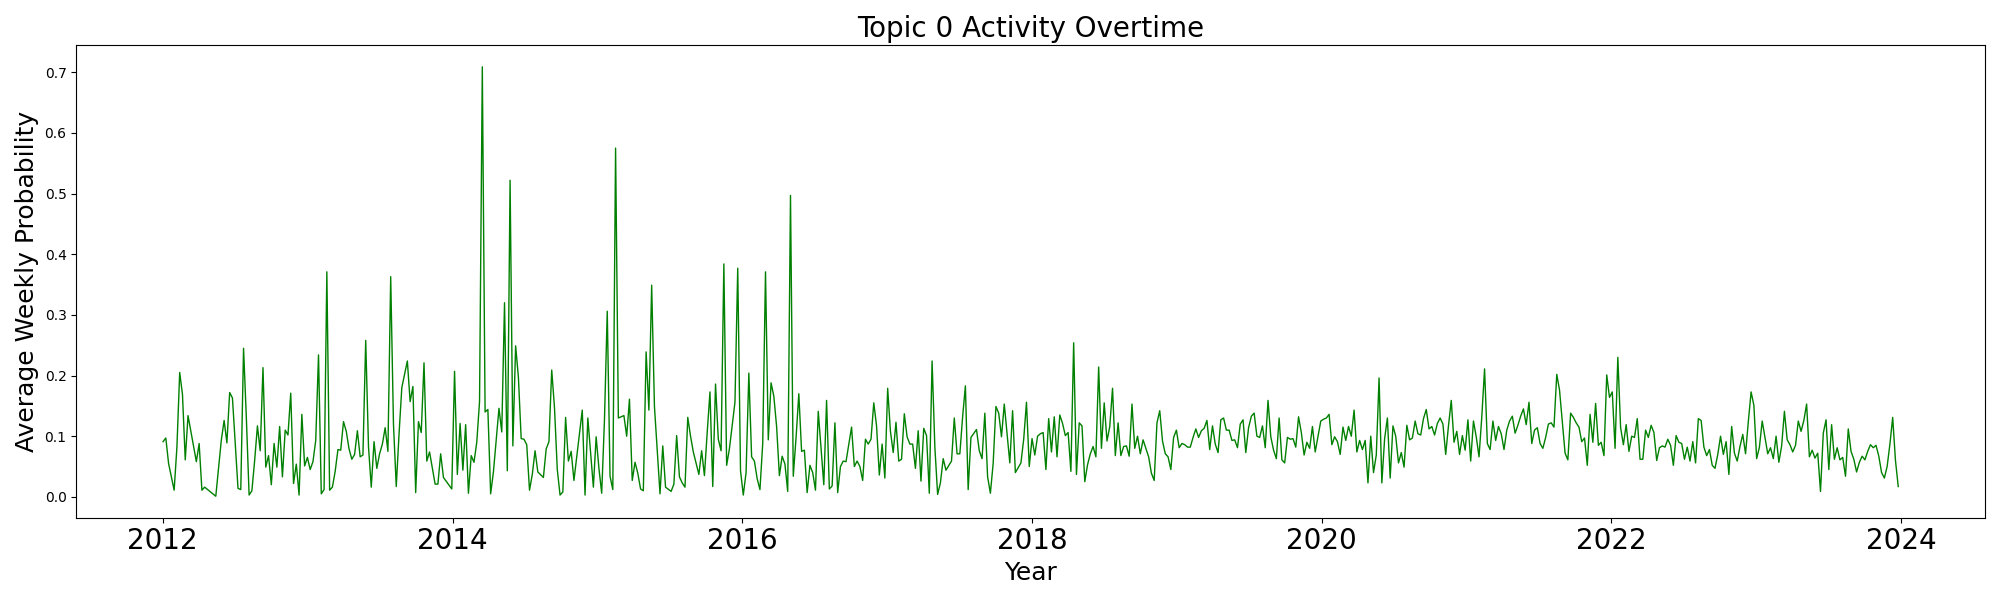

In [33]:
plt = ts_topic_plot(0)
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

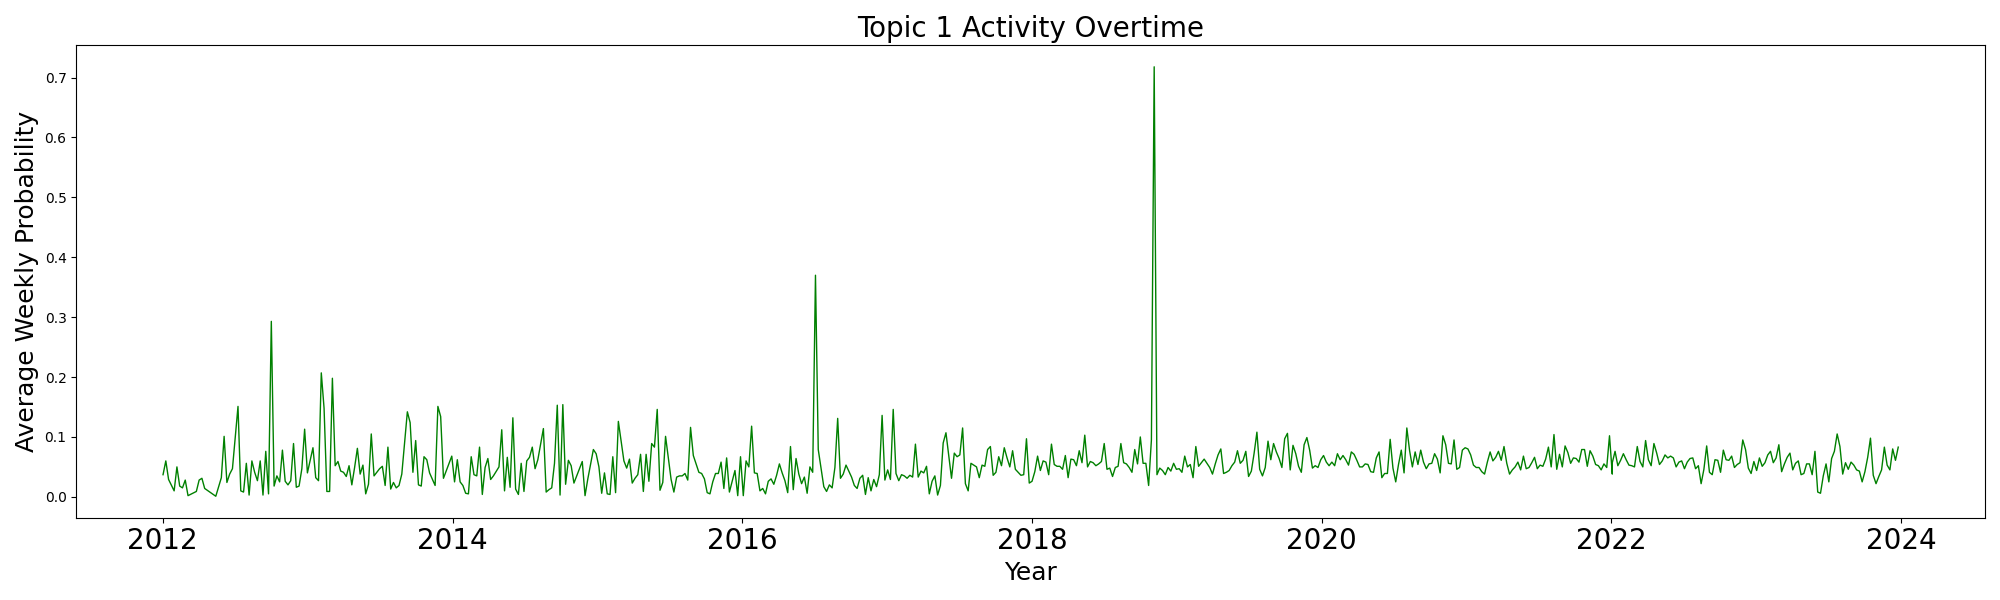

In [34]:
plt = ts_topic_plot(1)
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

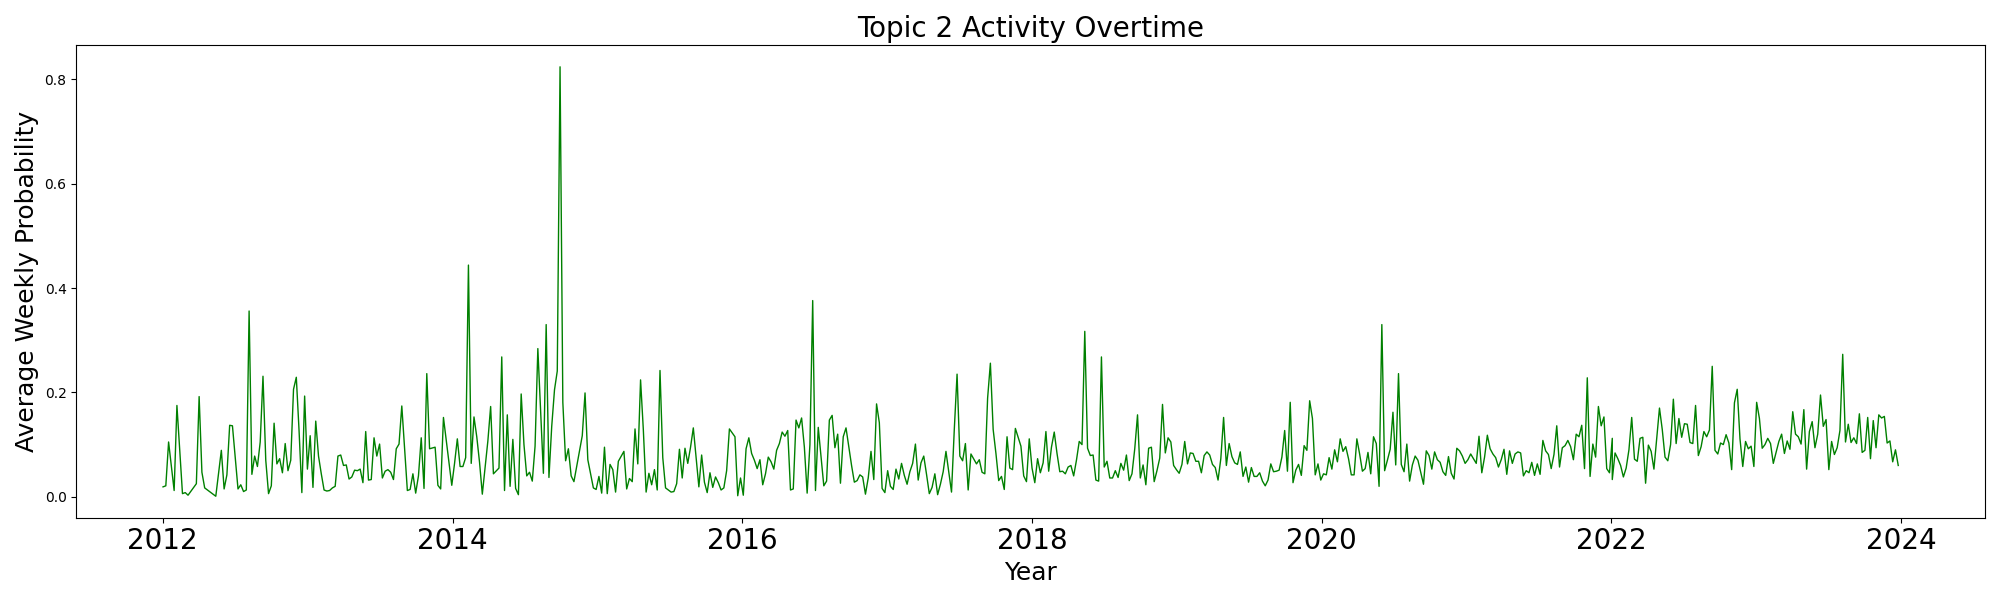

In [35]:
plt = ts_topic_plot(2)
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

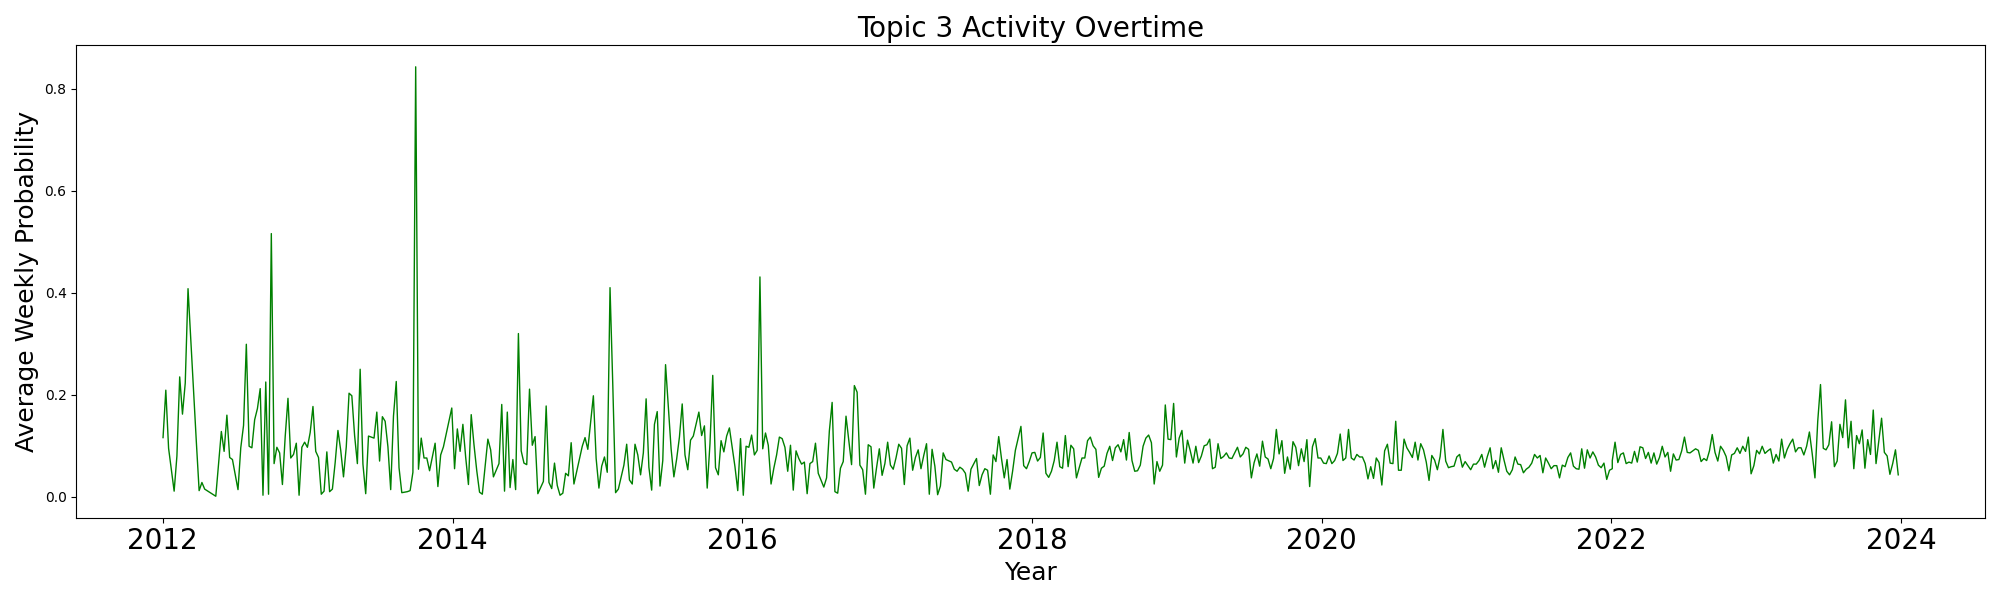

In [36]:
plt = ts_topic_plot(3)
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

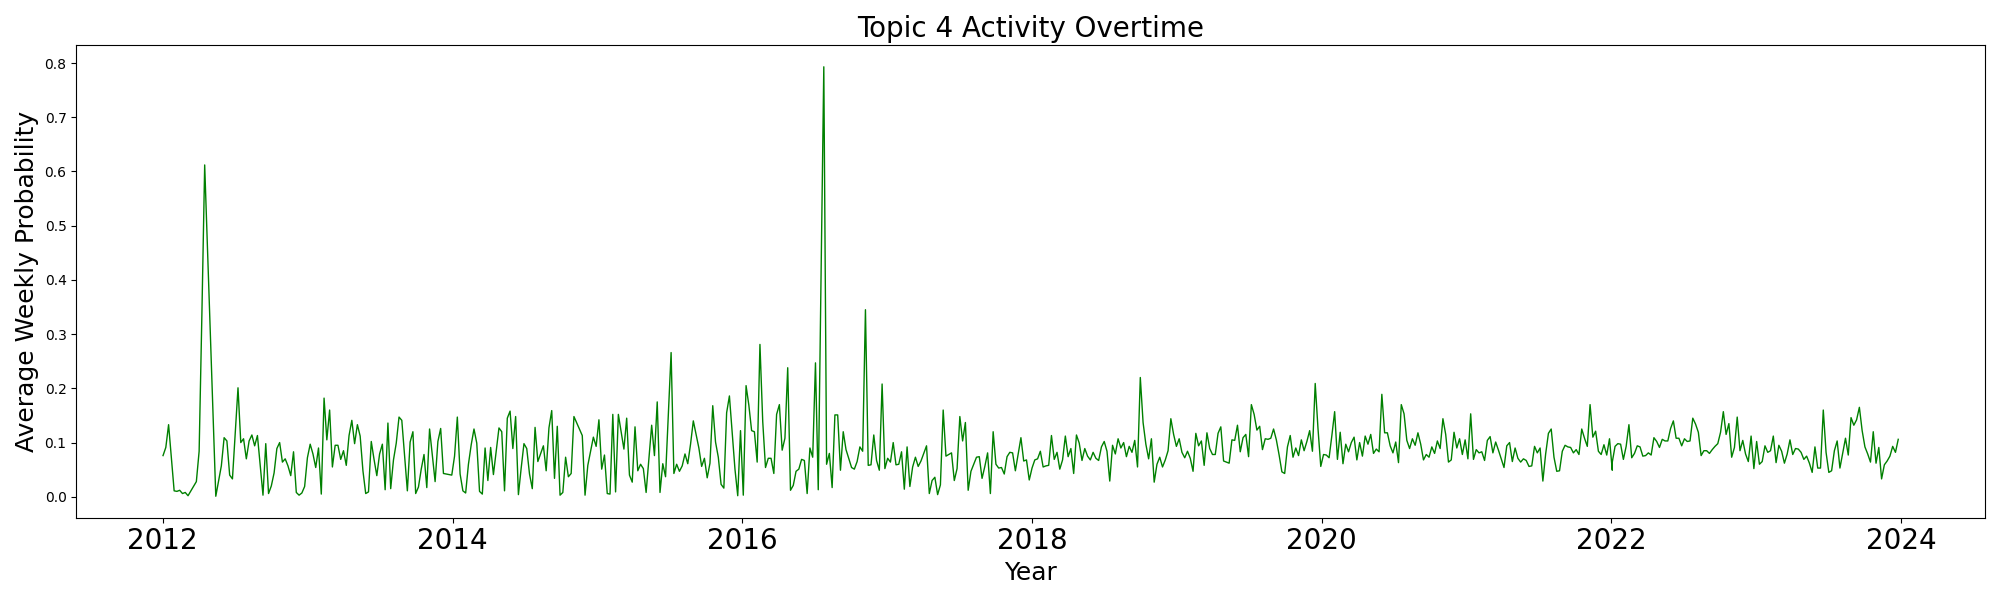

In [37]:
plt = ts_topic_plot(4)
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

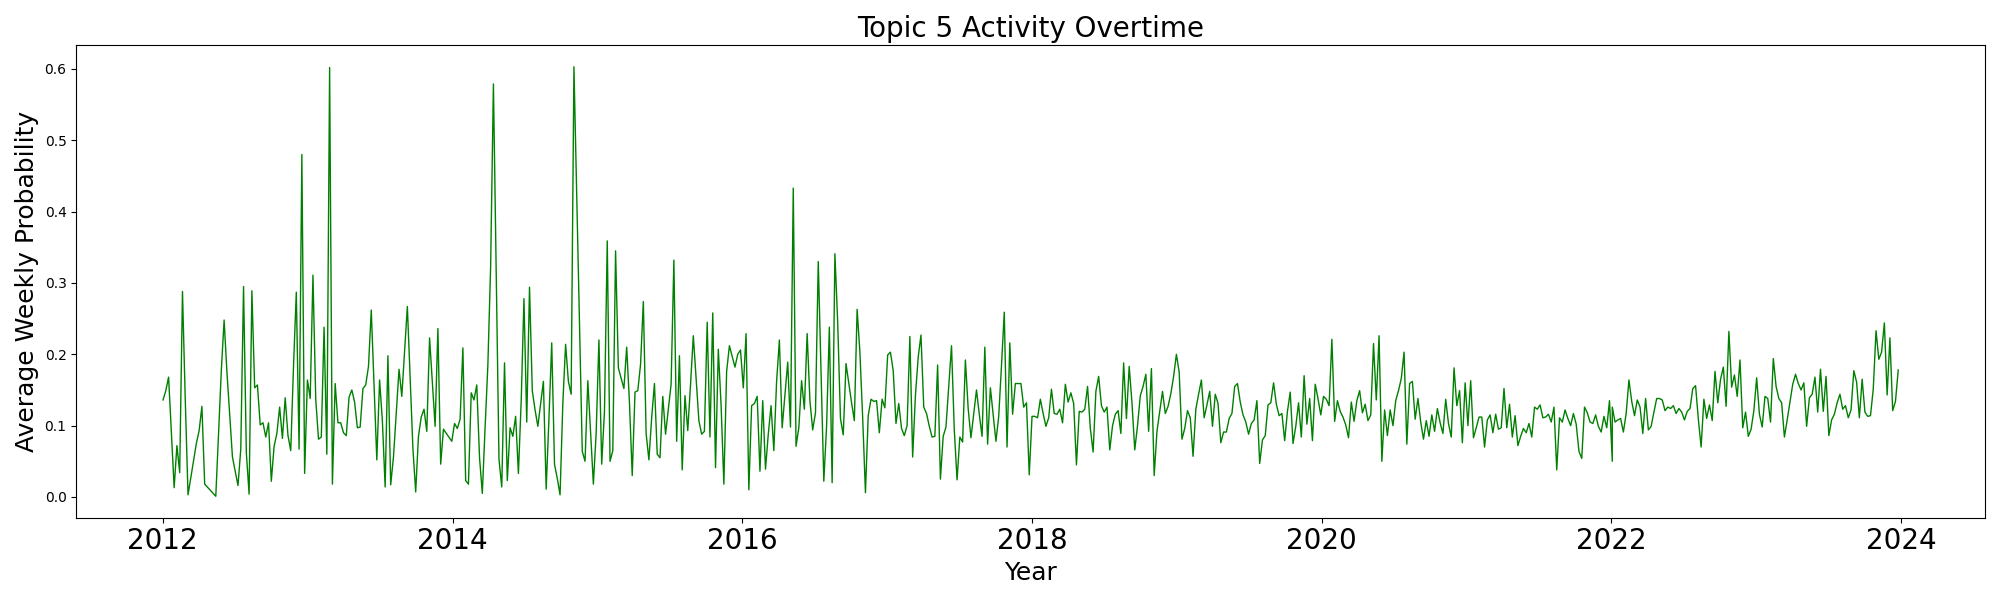

In [38]:
plt = ts_topic_plot(5)
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

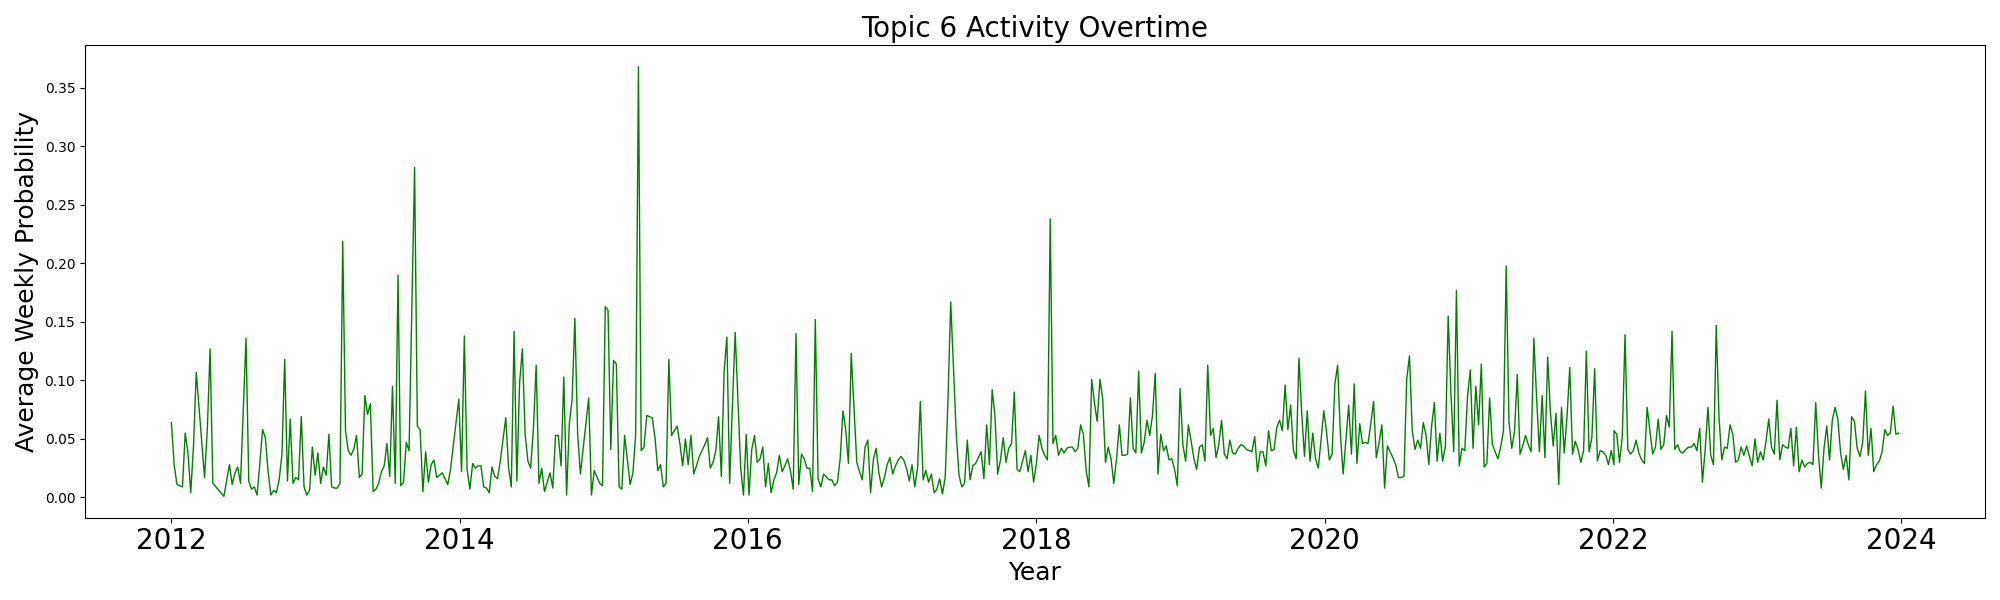

In [39]:
plt = ts_topic_plot(6)
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

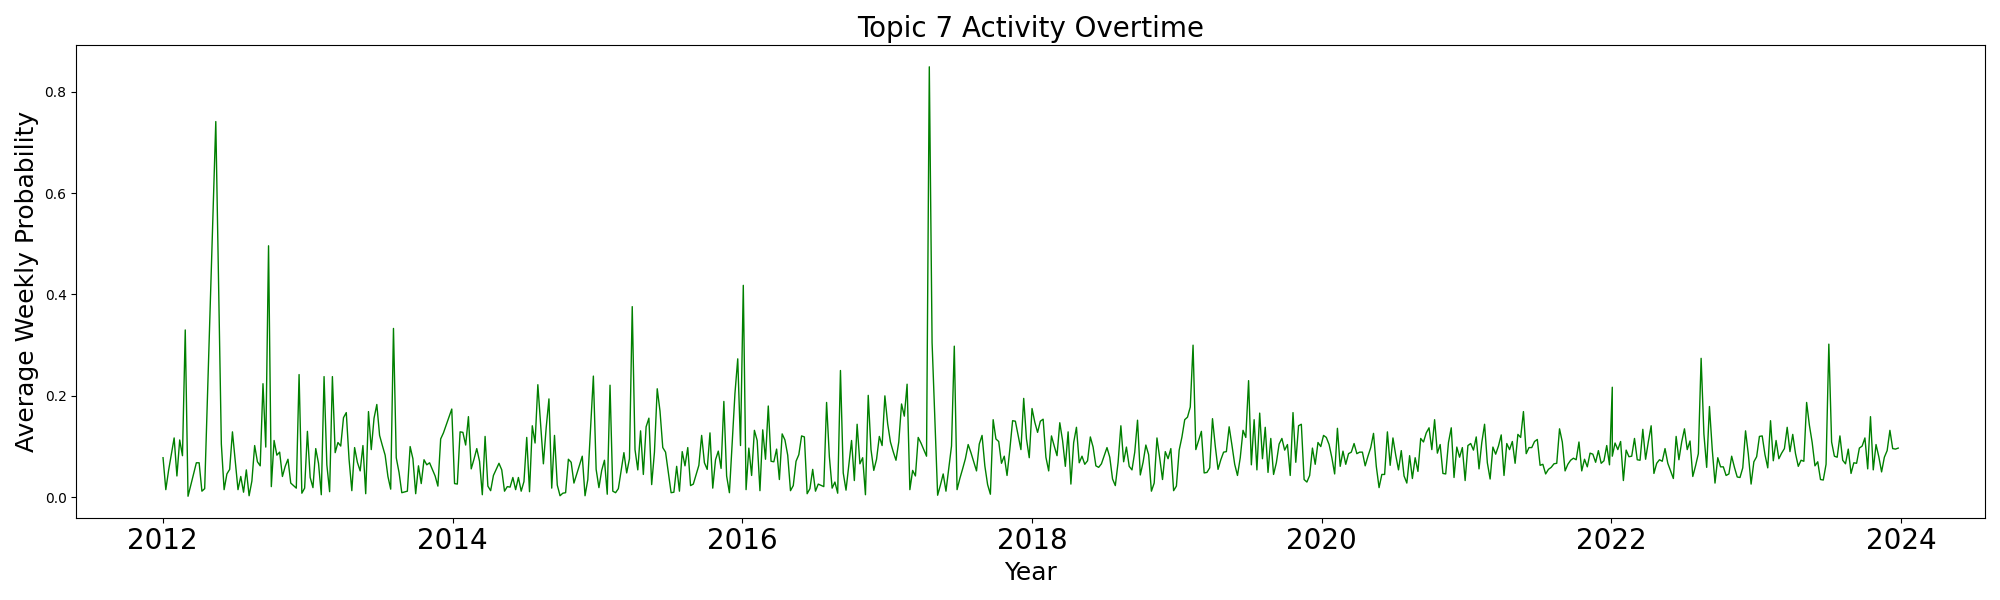

In [40]:
plt = ts_topic_plot(7)
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

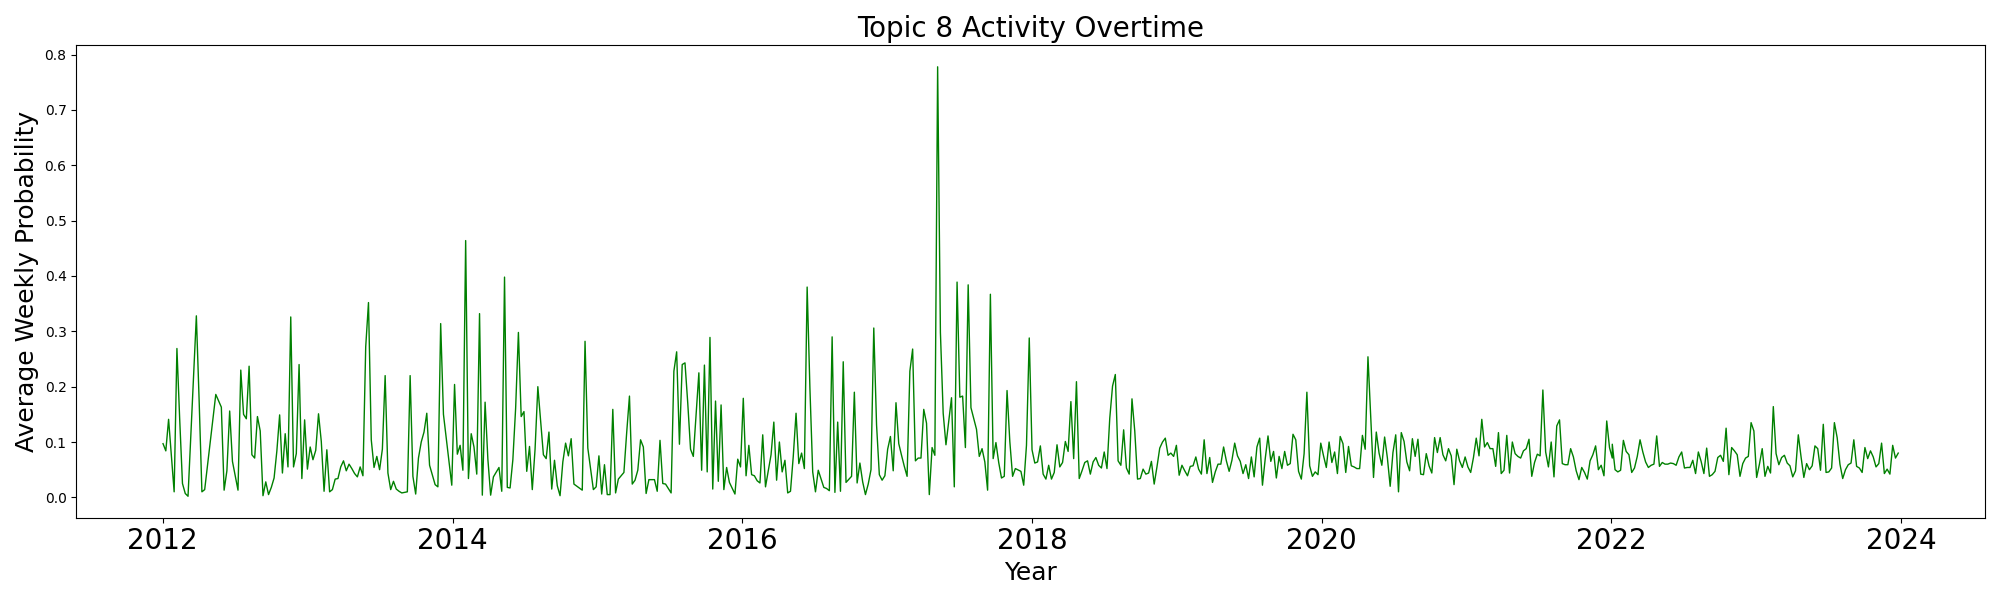

In [41]:
plt = ts_topic_plot(8)
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

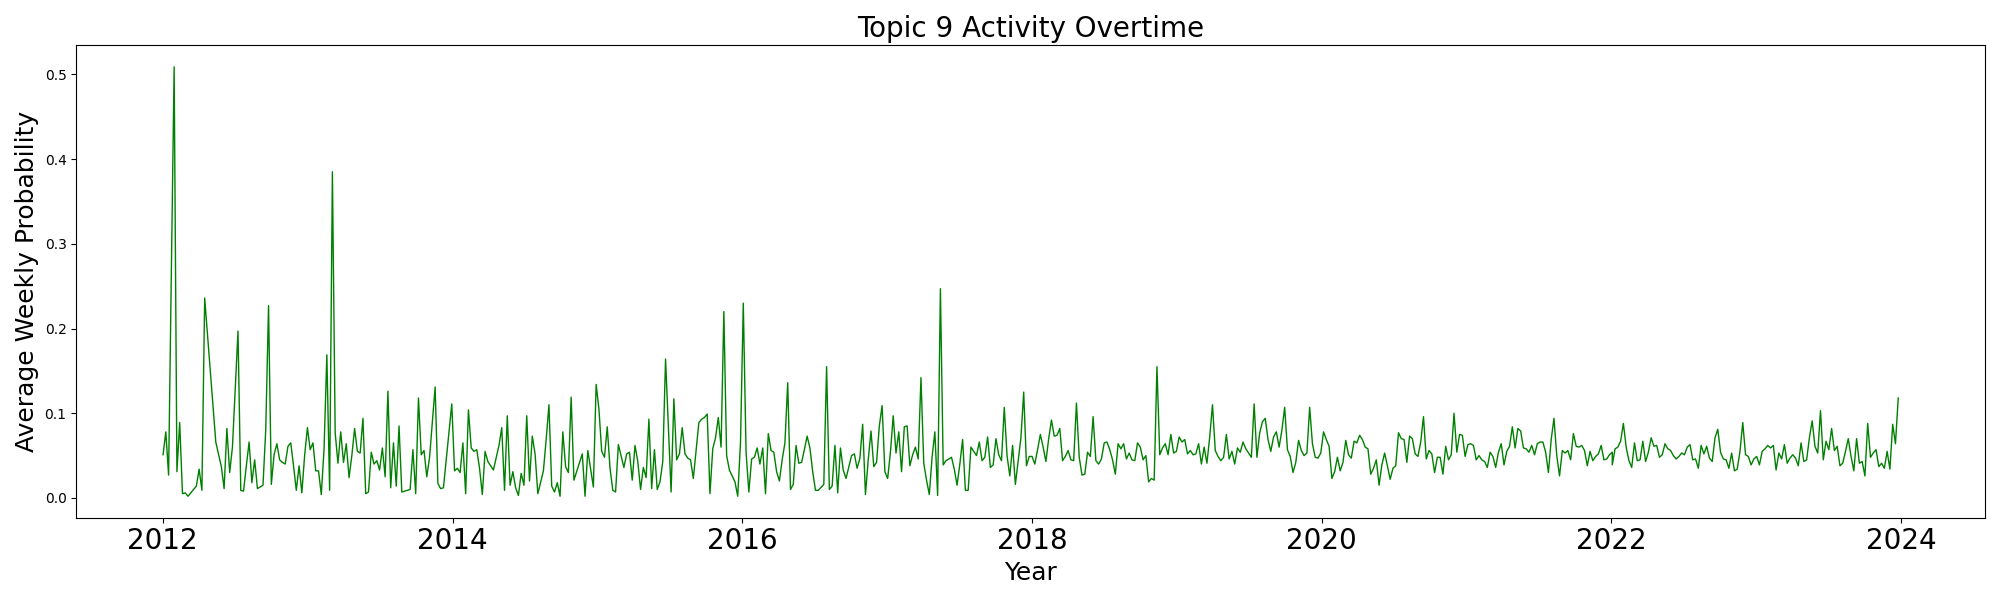

In [42]:
plt = ts_topic_plot(9)
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

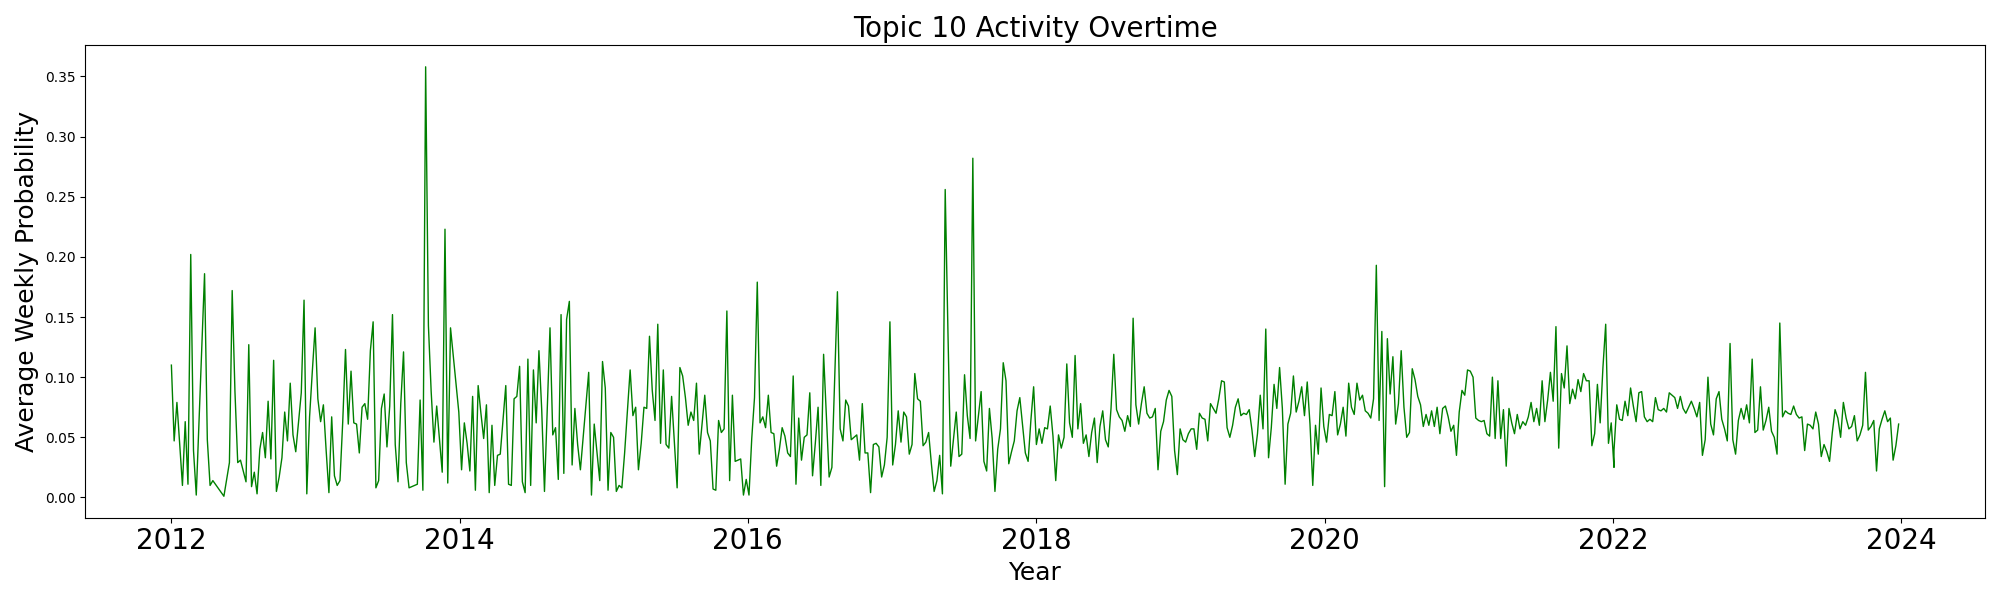

In [43]:
plt = ts_topic_plot(10)
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

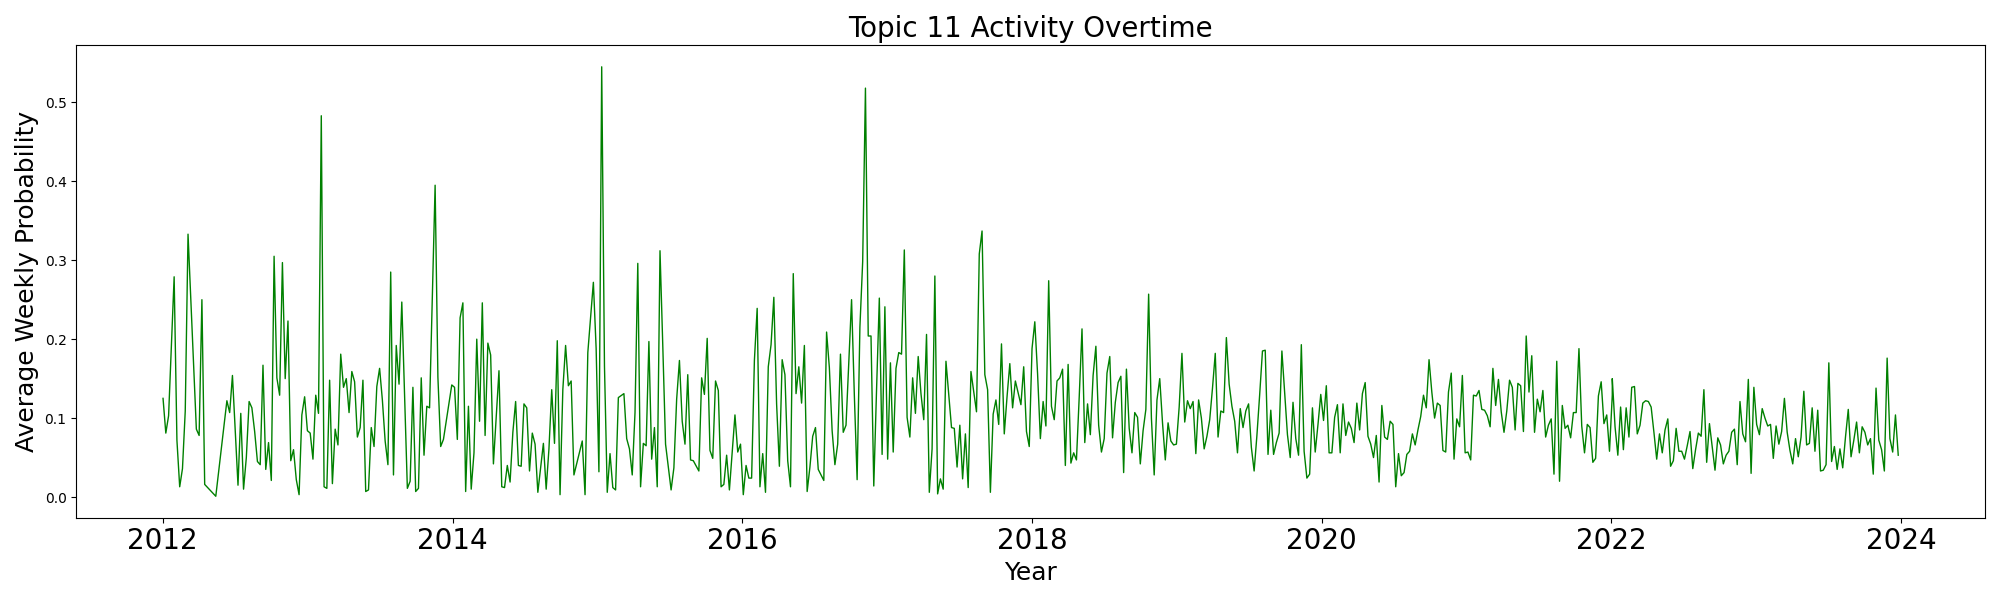

In [44]:
plt = ts_topic_plot(11)
%matplot plt